In [1]:
import os
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
import pickle
import numpy as np
from sklearn.ensemble import IsolationForest

##Carga de los Datos
Se hace la carga de los datos desde la ruta Data y se separa el dataframe solo con los datos de vino blanco

In [3]:
column_mapper = {
    'Service': 'fecha',
    'Relational Database Service($)': 'rds',
    'EC2-Instances($)': 'ec2',
    'FSx($)': 'fsx',
    'Elastic File System($)': 'efs',
    'EC2-Other($)': 'ec2_other',
    'CloudWatch($)': 'cloudwatch',
    'Elastic Load Balancing($)': 'elb',
    'S3($)': 's3',
    'Backup($)': 'backup',
    'Key Management Service($)': 'kms',
    'DataSync($)': 'data_sync',
    'Secrets Manager($)': 'secrets_manager',
    'Resilience Hub($)': 'resiliency',
    'Total costs($)': 'total_costs'
}


In [4]:
# Descargar el archivo del bucket in GCP
# https://storage.cloud.google.com/amico-umedellin/

# Datos con corte a Abril usar: "costs.csv"
# Datos con corte a 18 de Mayo usar: "costs_20250518.csv"

#data_file = "costs_20250518.csv"

#!gsutil cp gs://amico-umedellin/{data_file} ./Users/angeleduardogamarrarios/Repositorio_UDEM/MLops_AMICO/data/costs.csv
df = pd.read_csv('/Users/angeleduardogamarrarios/Repositorio_UDEM/MLops_AMICO/data/costs.csv')
df.head()

Service  Relational Database Service($)  EC2-Instances($)  \
0  Service total                    34131.482733      23531.788153   
1     2024-06-01                       31.851525          4.612654   
2     2024-06-02                       61.039787               NaN   
3     2024-06-03                       71.416393         63.161250   
4     2024-06-04                       54.833184         68.402379   

        FSx($)  Elastic File System($)  EC2-Other($)  CloudWatch($)  \
0  5152.073356             2830.548352   2132.939335    1543.902136   
1    12.472440                1.789663      0.611443       0.036701   
2    12.460864                1.789663      0.322181       0.016653   
3    12.654853                1.790544      5.613880       0.429317   
4    12.658942                1.791199      5.682819       0.459109   

        S3($)  Elastic Load Balancing($)   Backup($)  \
0  778.604880                 758.963353  530.170434   
1    1.156349                   2.160000    0.281071   
2    1.126354                   2.160000    0.281071   
3    1.119325                   2.160042    0.281071   
4    1.116106                   2.160139    0.281314   

   Key Management Service($)  DataSync($)  Secrets Manager($)  \
0                  91.476443     34.06381            0.178930   
1                   0.234161          NaN            0.000255   
2                   0.235058          NaN            0.000295   
3                   0.240077          NaN            0.000225   
4                   0.238019          NaN            0.000225   

   Resilience Hub($)  Total costs($)  
0                0.0    71516.191916  
1                0.0       55.206262  
2                NaN       79.431926  
3                NaN      158.866978  
4                NaN      147.623435

In [5]:
# Mapeo de columnas 
df.rename(columns=column_mapper, inplace=True)
# Elimina la fila con índice 0 y ka columna total_cost
df = df.drop(0, axis=0)
df = df.drop('total_costs', axis=1)

##Separar los datos en Test y Train

# Prepocesar datos

Para nuestro caso de analisis vamos a aplicar una normalizacion

In [7]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [8]:
N_SAMPLES = 351 
FEATURES = ['rds', 'ec2', 'fsx', 'efs', 
            'ec2_other', 'cloudwatch', 's3', 
            'elb', 'backup', 'kms', 'data_sync','secrets_manager','resiliency']


df = pd.DataFrame({
    col: np.random.rand(N_SAMPLES) * np.random.randint(1, 10) for col in FEATURES
})


X = df[FEATURES]

X_train_val, X_test = train_test_split(X, test_size=0.2, random_state=42)
X_train, X_val = train_test_split(X_train_val, test_size=0.25, random_state=42) # 0.25 * 0.80 = 0.20 (20% para Validation)


preprocessor_pipeline = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor_pipeline.fit(X_train)

X_train_scaled = preprocessor_pipeline.transform(X_train)
X_val_scaled = preprocessor_pipeline.transform(X_val)
X_test_scaled = preprocessor_pipeline.transform(X_test)

# 4. Verificación y Persistencia (MLOps)
print(f"Media de 'rds' en X_train original: {X_train['rds'].mean():.4f}")
print(f"Media de 'rds' en X_train escalado: {X_train_scaled[:, X_train.columns.get_loc('rds')].mean():.4f}") # La media debe ser cercana a 0

# Guardar el Pipeline (¡Esto es clave para el MLOps!)
# Debes guardar el objeto preprocessor_pipeline para usarlo en producción
# cuando llegue un nuevo dato de vino.

OUTPUT_DIR = "./data/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

with open(os.path.join(OUTPUT_DIR, "preprocessor_pipeline.pkl"), "wb") as f:
    pickle.dump(preprocessor_pipeline, f)

print("-" * 50)
print(f"✅ Pipeline y datos escalados listos. El preprocesador se guardó en: {OUTPUT_DIR}")


Media de 'rds' en X_train original: 3.4997
Media de 'rds' en X_train escalado: 0.0000
--------------------------------------------------
✅ Pipeline y datos escalados listos. El preprocesador se guardó en: ./data/


Entrenar
Antes de ejecutar lo siguiente correr en la terminal en la misma carpeta donde esta el notebook:

matar procesos que este arriba sudo lsof -i :5000

mlflow server --backend-store-uri sqlite:///backend.db

Levantar en otra terminal mlflow ui

kill 12345 


In [7]:
import mlflow

mlflow.set_tracking_uri("http://127.0.0.1:5000")

In [8]:
print(f"tracking URI: '{mlflow.get_tracking_uri()}'")

tracking URI: 'http://127.0.0.1:5000'


Isolation Forest (El Enfoque Robusto)
El Isolation Forest es rápido, escalable y muy robusto para datos multivariados con muchos outliers.

In [10]:
# --- CONFIGURACIÓN DEL MODELO ---

# El parámetro 'contamination' es crucial.
# Define la proporción esperada de anomalías (ej. 1% a 5% del total de días)
# Si no estás seguro, empieza con un valor conservador (0.01).
contamination_factor = 0.01

# Inicializar el modelo
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=contamination_factor,
    random_state=42,
    n_jobs=-1  # Usa todos los núcleos
)

# Entrenar el modelo (No supervisado: no necesita etiquetas)
iso_forest.fit(X_train)

# Predecir las anomalías: -1 para anomalía, 1 para dato normal
df_=X_train
df_['anomaly_iso_forest'] = iso_forest.predict(X_train)

# Obtener la 'Puntuación de Anomalía' (cuanto menor, más anómalo)
df_['score_iso_forest'] = iso_forest.decision_function(X_train)



In [11]:
# Mostrar los días anómalos
print("\n--- Anomalías detectadas por Isolation Forest (ejemplo) ---")
anomalies_if = df_[df_['anomaly_iso_forest'] == -1]
print(f"Total de anomalías detectadas: {len(anomalies_if)}")
print(anomalies_if.head())
# Nota: El umbral para la detección es ajustado por el 'contamination' que elegiste.


--- Anomalías detectadas por Isolation Forest (ejemplo) ---
Total de anomalías detectadas: 3
          rds       ec2       fsx       efs  ec2_other  cloudwatch        s3  \
253  0.649224  3.616990  0.185127  0.793261   2.827372    1.885248  0.471910   
311  0.086222  0.172074  2.995002  0.150169   8.729027    0.250787  0.090888   
200  6.368472  6.237288  0.607265  0.117462   0.358144    0.380771  0.442309   

          elb    backup       kms  data_sync  secrets_manager  resiliency  \
253  4.828490  1.359300  0.909959   1.978671         8.996364    7.063614   
311  1.437044  0.853642  0.661666   0.847847         8.650620    5.111973   
200  0.413432  3.671325  0.006749   0.201358         3.559676    5.296329   

     anomaly_iso_forest  score_iso_forest  
253                  -1         -0.026704  
311                  -1         -0.007305  
200                  -1         -0.028751  


Autoencoder (El Enfoque de Reconstrucción)
Un Autoencoder aprende a comprimir (codificar) y reconstruir (decodificar) patrones normales. Las anomalías tendrán un alto error de reconstrucción.

In [ ]:
import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense# --- CONFIGURACIÓN DEL AUTOENCODER ---

# 1. Definir la arquitectura
input_dim = X_train.shape[1]  # 13 variables log-escaladas
encoding_dim = 8  # Dimensión latente (comprimimos a 8 features)

input_layer = Input(shape=(input_dim,))
# Encoder (Comprimir la información)
encoded = Dense(encoding_dim * 2, activation='relu')(input_layer)
encoded = Dense(encoding_dim, activation='relu')(encoded)
# Decoder (Reconstruir la información)
decoded = Dense(encoding_dim * 2, activation='relu')(encoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)

# 2. Compilar y Entrenar (usamos MSE para medir el error de reconstrucción)
autoencoder.compile(optimizer='adam', loss='mse')

# Es crucial entrenar con suficientes épocas, pero usar un subconjunto de datos
# si el Autoencoder es demasiado sensible al ruido.
history = autoencoder.fit(
    X_train, X_train,
    epochs=5,
    batch_size=32,
    validation_split=0.1,  # Usar una pequeña parte para validación
    shuffle=True,
    verbose=0
)

# 3. Cálculo de la Puntuación de Anomalía (Error de Reconstrucción)
# Predecir la reconstrucción de los datos
X_pred = autoencoder.predict(X_train)

# Calcular el Error de Reconstrucción (Mean Squared Error - MSE) para cada día
mse = np.mean(np.power(X_train - X_pred, 2), axis=1)

# Asignar el MSE como la puntuación de anomalía
df_['error_reconstruccion'] = mse

# 4. Definir el Umbral
# Se usa el percentil (ej. el percentil 95 o 99) del error de reconstrucción
# para establecer el umbral de detección.
umbral_ae = np.quantile(mse, 0.99)  # Marcamos el 1% de los días con mayor error

df_['anomaly_autoencoder'] = np.where(df['error_reconstruccion'] > umbral_ae, -1, 1)

print("\n--- Anomalías detectadas por Autoencoder (ejemplo) ---")
anomalies_ae = df_[df_['anomaly_autoencoder'] == -1]
print(f"Total de anomalías detectadas: {len(anomalies_ae)}")
print(anomalies_ae[['error_reconstruccion']].sort_values(by='error_reconstruccion', ascending=False).head())

One-Class SVM (OC-SVM)
OC-SVM intenta encontrar un hiperplano que separe la mayoría de los datos "normales" del origen, marcando los puntos que quedan fuera como anomalías.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM  # Importación para OC-SVM
from sklearn.neighbors import LocalOutlierFactor # Importación para LOF

# --- CONFIGURACIÓN DEL MODELO ---

# El parámetro 'nu' es el equivalente al 'contamination' factor,
# representando la fracción superior de anomalías esperadas.
# 'gamma' define la influencia de un punto de entrenamiento individual
# (usamos 'auto' para que se calibre por 1/n_features).
contamination_factor = 0.01  # Esperamos un 1% de anomalías

# Inicializar el modelo OC-SVM
oc_svm = OneClassSVM(
    kernel='rbf',  # Kernel de función de base radial, común en anomalías
    gamma='auto',
    nu=contamination_factor
)

# Entrenar el modelo
oc_svm.fit(X_train)

# Predecir las anomalías: -1 para anomalía, 1 para dato normal
df_['anomaly_oc_svm'] = oc_svm.predict(X_train)

# Obtener la 'Puntuación de Anomalía' (cuanto menor, más anómalo)
df_['score_oc_svm'] = oc_svm.decision_function(X_train)

# Mostrar los días anómalos
print("\n--- Anomalías detectadas por One-Class SVM ---")
anomalies_ocsvm = df_[df_['anomaly_oc_svm'] == -1]
print(f"Total de anomalías detectadas: {len(anomalies_ocsvm)}")
print(anomalies_ocsvm.sort_values(by='score_oc_svm').head())

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- anomaly_oc_svm


Local Outlier Factor (LOF)
LOF es un modelo basado en la densidad. Mide cuán aislado está un punto con respecto a sus vecinos más cercanos. Un score LOF mucho mayor que 1 indica una anomalía.

In [ ]:
# --- CONFIGURACIÓN DEL MODELO ---

# 'n_neighbors': Número de vecinos a considerar (típicamente entre 20 y 100).
# 'contamination': La proporción esperada de anomalías (similar a Isolation Forest).
n_neighbors = 20
contamination_factor = 0.01

# Inicializar el modelo LOF
# Nota: LOF se inicializa en 'novelty=False' para fines de predicción.
lof = LocalOutlierFactor(
    n_neighbors=n_neighbors,
    contamination=contamination_factor,
    novelty=False  # Para usarlo en modo detección de outliers en el conjunto de entrenamiento
)

# Ajustar y predecir (LOF realiza el ajuste y la predicción en un solo paso)
df_['anomaly_lof'] = lof.fit_predict(X_train)

# La 'Puntuación de Anomalía' de LOF es el factor LOF (cuanto mayor, más anómalo)
# Nota: LOF devuelve el Factor de Anormalidad Local Negativo. Lo negamos para que
# los valores más altos sigan significando mayor anomalía, como es habitual.
df_['score_lof'] = -lof.negative_outlier_factor_

# Mostrar los días anómalos
print("\n--- Anomalías detectadas por Local Outlier Factor (LOF) ---")
anomalies_lof = df_[df_['anomaly_lof'] == -1]
print(f"Total de anomalías detectadas: {len(anomalies_lof)}")
print(anomalies_lof.sort_values(by='score_lof', ascending=False).head())


--- Anomalías detectadas por Local Outlier Factor (LOF) ---
Total de anomalías detectadas: 3
          rds       ec2       fsx       efs  ec2_other  cloudwatch        s3  \
139  0.084677  0.444435  2.261355  1.306703   3.380884    4.262028  0.686421   
288  1.025066  1.416756  1.971582  1.031717   0.340647    0.405752  7.048601   
127  1.713478  0.130350  0.328706  1.850312   0.523341    4.617519  0.181735   

          elb    backup       kms  data_sync  secrets_manager  resiliency  \
139  0.088982  5.963332  2.936591   0.304802         0.869633    0.233834   
288  2.373703  0.058973  2.710268   4.748330         0.178082    0.822763   
127  7.081976  2.733514  1.617856   5.492793         2.732596    0.399338   

     anomaly_iso_forest  anomaly_oc_svm  anomaly_lof  score_lof  
139                  -1              -1           -1   1.230749  
288                   1               1           -1   1.117817  
127                  -1              -1           -1   1.105833  


Encontrar los mejores hiperparametros con Optuna

In [23]:
import pandas as pd
import numpy as np
import optuna
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

# --- ⚠️ PREPARACIÓN DE DATOS (Asumimos que estas variables existen) ---
# X_scaled: El DataFrame con tus 13 variables de AWS log-transformadas y escaladas.
# is_anomaly: Una Serie/Array con etiquetas binarias (1 para normal, -1 para anómalo)
# Si no tienes etiquetas, reemplaza este bloque por la carga de tus datos reales:
# --------------------------------------------------------------------------------

# Datos de ejemplo para fines de demostración de Optuna
n_samples = 500
n_features = 13
X_scaled = pd.DataFrame(np.random.randn(n_samples, n_features))
# Creamos etiquetas de ejemplo (el 2% son anomalías)
is_anomaly = np.ones(n_samples)
is_anomaly[:10] = -1 
np.random.shuffle(is_anomaly)

# --------------------------------------------------------------------------------

In [20]:
X_scaled.head()

0         1         2         3         4         5         6   \
0 -0.424361 -1.055516 -0.808378 -1.665275  1.648195 -0.497938  1.056095   
1  2.028379  1.630671 -0.542034  0.157437  1.170907  1.883032  0.502141   
2 -0.060569  1.735389 -0.526768 -1.003225  0.325567 -1.513200  0.882503   
3 -0.937078 -0.695503  0.322884 -2.059862  1.355269  1.342610 -0.277638   
4 -0.347503 -1.493817  1.101798 -0.358686  0.753176 -0.272140  1.037832   

         7         8         9         10        11        12  
0  0.730356  1.177075 -0.237201 -0.064115 -0.276937  1.094747  
1  1.518919  1.447617 -0.833982  1.238974  1.135978  1.302430  
2 -0.797573  1.834674  0.217372  0.132964  0.818702 -0.799496  
3 -0.522198 -1.148532  0.025492 -1.145132 -0.603903  0.515021  
4  0.762307 -1.549361 -1.247889 -1.009594  1.120964 -1.170470

In [ ]:
def objective_lof(trial):
    """
    Función objetivo para optimizar los hiperparámetros de LOF usando Optuna.
    """
    
    # 1. Sugerencia de Hiperparámetros
    
    # n_neighbors: Es el número de vecinos a considerar (típicamente entre 5 y 100)
    n_neighbors = trial.suggest_int('n_neighbors', 5, 100, step=5)
    
    # contamination: Fracción esperada de anomalías (típicamente entre 0.001 y 0.1)
    # Usamos logarítmico para explorar mejor el rango bajo.
    contamination = trial.suggest_float('contamination', 0.001, 0.1, log=True)
    
    # 2. Inicialización y Entrenamiento del Modelo
    
    # Usamos novelty=False ya que estamos detectando outliers en el conjunto de entrenamiento
    lof = LocalOutlierFactor(
        n_neighbors=n_neighbors,
        contamination=contamination,
        novelty=False
    )
    
    # 3. Ajuste y Predicción
    # LOF ajusta y predice en el mismo paso cuando novelty=False
    y_pred = lof.fit_predict(X_scaled)
    
    # 4. Evaluación
    # Calculamos el F1-Score (una buena métrica para clases desequilibradas)
    # 'pos_label=-1' indica que la clase minoritaria (anomalía) es -1.
    f1 = f1_score(is_anomaly, y_pred, pos_label=-1)
    
    # Optuna busca maximizar este valor
    return f1

# --- Ejecutar el estudio de Optuna ---

study = optuna.create_study(direction='maximize')
# Se recomienda un número mayor de pruebas (n_trials) en un caso real
study.optimize(objective_lof, n_trials=50) 

# Imprimir resultados
print("\n--- Resultados de la Optimización ---")
print(f"Mejor F1-Score encontrado: {study.best_value:.4f}")
print("Mejores Hiperparámetros:")
print(study.best_params)

# --- Implementación Final ---
best_params = study.best_params
final_lof = LocalOutlierFactor(
    n_neighbors=best_params['n_neighbors'],
    contamination=best_params['contamination'],
    novelty=False
)

# Ajustar y obtener la puntuación de anomalía final
df_scaled['anomaly_final'] = final_lof.fit_predict(X_scaled)
df_scaled['score_final'] = -final_lof.negative_outlier_factor_

[I 2025-10-25 07:03:12,264] A new study created in memory with name: no-name-3dbf0cb6-d653-4390-9cda-255a41ff82ff
[I 2025-10-25 07:03:12,292] Trial 0 finished with value: 0.0 and parameters: {'n_neighbors': 100, 'contamination': 0.013349565652666439}. Best is trial 0 with value: 0.0.
[I 2025-10-25 07:03:12,309] Trial 1 finished with value: 0.0 and parameters: {'n_neighbors': 95, 'contamination': 0.002847570770203186}. Best is trial 0 with value: 0.0.
[I 2025-10-25 07:03:12,322] Trial 2 finished with value: 0.0 and parameters: {'n_neighbors': 75, 'contamination': 0.018152169669224984}. Best is trial 0 with value: 0.0.
[I 2025-10-25 07:03:12,332] Trial 3 finished with value: 0.0 and parameters: {'n_neighbors': 55, 'contamination': 0.08877993927454159}. Best is trial 0 with value: 0.0.
[I 2025-10-25 07:03:12,339] Trial 4 finished with value: 0.0 and parameters: {'n_neighbors': 20, 'contamination': 0.006890369614848173}. Best is trial 0 with value: 0.0.
[I 2025-10-25 07:03:12,345] Trial 5 


--- Resultados de la Optimización ---
Mejor F1-Score encontrado: 0.0000
Mejores Hiperparámetros:
{'n_neighbors': 100, 'contamination': 0.013349565652666439}


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

/var/folders/nt/4ldzwbz51gg979lps65n9sjr0000gn/T/ipykernel_16533/2665446357.py:6: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

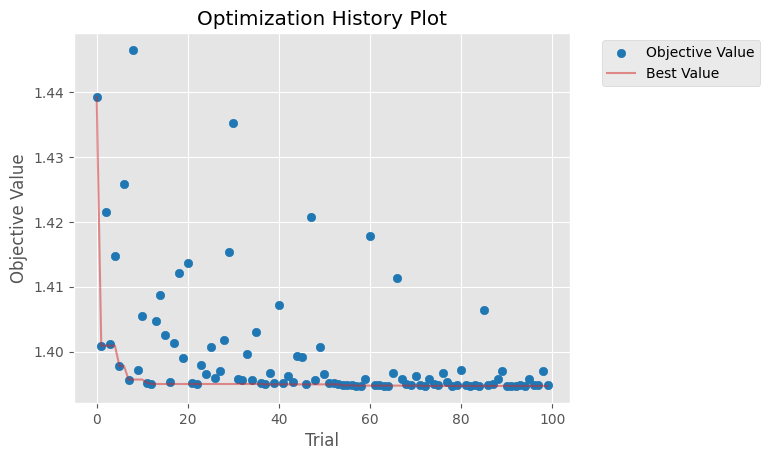

In [15]:
# Visualize optimization history
import matplotlib.pyplot as plt


# Optimization history
optuna.visualization.matplotlib.plot_optimization_history(study)

/var/folders/nt/4ldzwbz51gg979lps65n9sjr0000gn/T/ipykernel_16533/1036994904.py:1: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

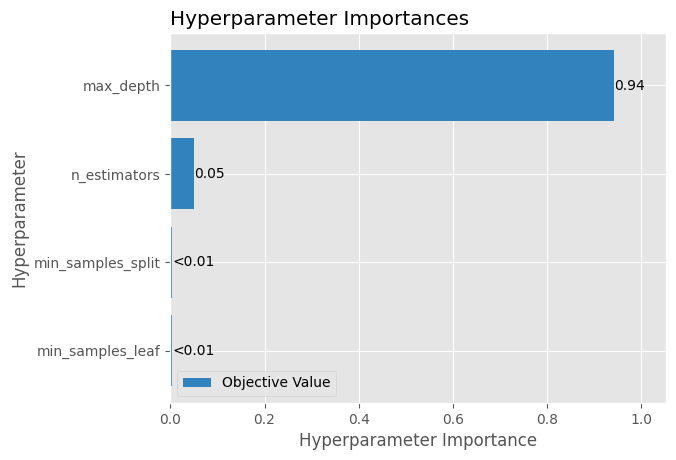

In [16]:
optuna.visualization.matplotlib.plot_param_importances(study)

In [19]:
# Register the best model
with mlflow.start_run(run_id=study.best_trial.user_attrs.get('mlflow_run_id')):
    # Log the model
    mlflow.sklearn.log_model(
        best_model, 
        "model",
        registered_model_name="White_wine_experiment1_RFR"
    )
    
    # Log preprocessing pipeline
    mlflow.sklearn.log_model(
        preprocessor_pipeline, 
        "preprocessor_pipeline",
        registered_model_name="White_wine_experiment1_RFR_preprocesor"
    )

2025/10/03 16:41:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/03 16:41:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/03 16:41:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'White_wine_experiment1_RFR' already exists. Creating a new version of this model...
2025/10/03 16:41:27 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: White_wine_experiment1_RFR, version 3
Created version '3' of model 'White_wine_experiment1_RFR'.
2025/10/03 16:41:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/03 16:41:27 WARNING mlflow.sklearn: Model was missing functio

🏃 View run loud-kit-787 at: http://127.0.0.1:5000/#/experiments/1/runs/8e04e0aded8649a484bc44499d52e377
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


Created version '1' of model 'White_wine_experiment1_RFR_preprocesor'.
